# Documentation Search System using TF-IDF

This notebook demonstrates a documentation search system using TF-IDF (Term Frequency-Inverse Document Frequency).

Engineers can search for technical documentation by typing queries like:
- "how to configure SSL certificates"
- "database connection setup"
- "API authentication methods"

The system returns the most relevant documentation pages ranked by TF-IDF similarity.

**Why TF-IDF over Bag-of-Words?**
- Common words like "how," "to," "the" get low importance (automatically)
- Rare, distinctive technical terms get high importance
- Better ranking of search results

**Author**: Siva Sai Yadav

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## Part 1: Create Documentation Dataset

We'll create a realistic technical documentation dataset with 20 documents covering:
- **Configuration**: SSL, database, server setup
- **API**: Authentication, endpoints, rate limiting
- **Troubleshooting**: Errors, debugging, logs
- **Development**: Code examples, best practices

In [2]:
# Technical documentation pages
documentation = {
    'doc_id': [
        'DOC001', 'DOC002', 'DOC003', 'DOC004', 'DOC005',
        'DOC006', 'DOC007', 'DOC008', 'DOC009', 'DOC010',
        'DOC011', 'DOC012', 'DOC013', 'DOC014', 'DOC015',
        'DOC016', 'DOC017', 'DOC018', 'DOC019', 'DOC020'
    ],
    'title': [
        'SSL Certificate Configuration',
        'Database Connection Setup',
        'API Authentication Guide',
        'Server Deployment Steps',
        'Environment Variables Setup',
        'REST API Endpoints Reference',
        'Rate Limiting Configuration',
        'OAuth2 Implementation Guide',
        'Database Migration Tutorial',
        'HTTPS Configuration',
        'Debugging Application Errors',
        'Performance Optimization Tips',
        'Logging Best Practices',
        'Error Handling Strategies',
        'Code Review Guidelines',
        'API Versioning Strategy',
        'Docker Container Setup',
        'CI/CD Pipeline Configuration',
        'Security Best Practices',
        'Database Backup Procedures'
    ],
    'content': [
        # Configuration docs
        "To configure SSL certificates for your application, first generate a certificate signing request. Install the SSL certificate on your web server. Configure HTTPS in your application settings. Test the SSL configuration using online tools. Ensure certificate renewal is automated.",

        "Database connection setup requires configuring the connection string in your environment variables. Install the appropriate database driver for your programming language. Test the database connection before deployment. Use connection pooling for better performance. Handle connection errors gracefully.",

        "API authentication can be implemented using API keys, OAuth tokens, or JWT tokens. Store credentials securely in environment variables. Implement rate limiting to prevent abuse. Use HTTPS for all API requests. Validate tokens on every request.",

        "Server deployment involves setting up the production environment, configuring firewall rules, and installing necessary dependencies. Deploy your application code to the server. Configure reverse proxy settings. Set up monitoring and logging. Test the deployment thoroughly.",

        "Environment variables should be used to store sensitive configuration data like API keys and database credentials. Never commit environment files to version control. Use different environment files for development, staging, and production. Document all required environment variables.",

        # API docs
        "REST API endpoints follow standard HTTP methods. GET requests retrieve data, POST creates new resources, PUT updates existing resources, DELETE removes resources. All endpoints return JSON responses. Use proper HTTP status codes in responses.",

        "Rate limiting protects your API from abuse by restricting the number of requests per time window. Implement rate limiting using API keys or IP addresses. Return 429 status code when rate limit is exceeded. Include rate limit headers in API responses.",

        "OAuth2 implementation provides secure authorization for third-party applications. Configure OAuth providers and redirect URLs. Implement authorization code flow for web applications. Store access tokens securely. Handle token refresh automatically.",

        "Database migration ensures schema changes are applied consistently across environments. Write migration scripts for schema changes. Test migrations on development environment first. Use version control for migration files. Implement rollback procedures for failed migrations.",

        "HTTPS configuration secures communication between client and server. Obtain SSL/TLS certificates from a trusted certificate authority. Configure web server to use HTTPS protocol. Redirect HTTP traffic to HTTPS. Enable HTTP Strict Transport Security headers.",

        # Troubleshooting docs
        "Debugging application errors requires systematic troubleshooting. Check application logs for error messages and stack traces. Use debugging tools to inspect application state. Test in isolation to reproduce the error. Fix the root cause, not just symptoms.",

        "Performance optimization improves application speed and efficiency. Profile your application to identify bottlenecks. Optimize database queries using indexes. Implement caching for frequently accessed data. Use asynchronous processing for long-running tasks.",

        "Logging best practices help with troubleshooting and monitoring. Log at appropriate levels: DEBUG, INFO, WARNING, ERROR. Include contextual information in log messages. Use structured logging for better analysis. Implement log rotation to manage disk space.",

        "Error handling strategies prevent application crashes. Use try-catch blocks to handle exceptions gracefully. Return meaningful error messages to users. Log errors with full context for debugging. Implement circuit breakers for external service calls.",

        # Development docs
        "Code review guidelines ensure code quality and knowledge sharing. Review code for functionality, readability, and maintainability. Check for security vulnerabilities and performance issues. Provide constructive feedback. Approve changes only when all concerns are addressed.",

        "API versioning strategy allows backward compatibility when making changes. Use URL versioning or header versioning. Maintain documentation for all API versions. Deprecate old versions gradually. Communicate version changes to API consumers.",

        "Docker container setup packages your application with all dependencies. Write a Dockerfile with base image and dependencies. Build container images for each environment. Use docker-compose for multi-container applications. Push images to container registry.",

        "CI/CD pipeline configuration automates testing and deployment. Configure automated tests to run on every commit. Set up staging environment for testing. Implement automated deployment to production. Include rollback procedures in pipeline.",

        "Security best practices protect your application from vulnerabilities. Validate and sanitize all user inputs. Use parameterized queries to prevent SQL injection. Implement authentication and authorization properly. Keep dependencies updated to patch security vulnerabilities.",

        "Database backup procedures ensure data can be recovered after failures. Schedule regular automated backups. Test backup restoration procedures. Store backups in secure off-site location. Document backup and recovery procedures."
    ],
    'category': [
        'Configuration', 'Configuration', 'Configuration', 'Configuration', 'Configuration',
        'API', 'API', 'API', 'Configuration', 'Configuration',
        'Troubleshooting', 'Troubleshooting', 'Troubleshooting', 'Troubleshooting',
        'Development', 'API', 'Development', 'Development', 'Development', 'Configuration'
    ]
}

# Create DataFrame
df = pd.DataFrame(documentation)

print("="*70)
print("DOCUMENTATION DATABASE")
print("="*70)
print(f"Total documents: {len(df)}")
print(f"\nCategory distribution:")
print(df['category'].value_counts())
print(f"\nSample documents:")
df[['doc_id', 'title', 'category']].head(10)

DOCUMENTATION DATABASE
Total documents: 20

Category distribution:
category
Configuration      8
API                4
Troubleshooting    4
Development        4
Name: count, dtype: int64

Sample documents:


,doc_id,title,category
0,DOC001,SSL Certificate Configuration,Configuration
1,DOC002,Database Connection Setup,Configuration
2,DOC003,API Authentication Guide,Configuration
3,DOC004,Server Deployment Steps,Configuration
4,DOC005,Environment Variables Setup,Configuration
5,DOC006,REST API Endpoints Reference,API
6,DOC007,Rate Limiting Configuration,API
7,DOC008,OAuth2 Implementation Guide,API
8,DOC009,Database Migration Tutorial,Configuration
9,DOC010,HTTPS Configuration,Configuration


## Part 2: Understanding TF-IDF vs Bag-of-Words

Let's first see why BoW isn't ideal for search, then see how TF-IDF improves it.

In [3]:
# Compare BoW and TF-IDF on a sample query
sample_query = "configure SSL certificate"
sample_docs = [
    "To configure SSL certificates for your application, first generate a certificate signing request.",
    "Database connection setup requires configuring the connection string.",
    "Configure reverse proxy settings for your web server."
]

print("="*70)
print("COMPARING BAG-OF-WORDS vs TF-IDF")
print("="*70)
print(f"\nQuery: '{sample_query}'")
print(f"\nDocuments:")
for i, doc in enumerate(sample_docs, 1):
    print(f"  Doc {i}: {doc}")

# Bag-of-Words
bow_vectorizer = CountVectorizer()
bow_matrix = bow_vectorizer.fit_transform(sample_docs + [sample_query])
bow_query = bow_matrix[-1]
bow_docs = bow_matrix[:-1]

print("\n--- BAG-OF-WORDS APPROACH ---")
print(f"Vocabulary: {bow_vectorizer.get_feature_names_out()}")
print(f"\nWord 'configure' appears in all 3 docs (not distinctive)")
print(f"Word 'ssl' appears in only 1 doc (very distinctive)")
print(f"\nBoW treats both equally - just counts occurrences")

# TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(sample_docs + [sample_query])
tfidf_query = tfidf_matrix[-1]
tfidf_docs = tfidf_matrix[:-1]

print("\n--- TF-IDF APPROACH ---")
feature_names = tfidf_vectorizer.get_feature_names_out()

# Show TF-IDF scores for 'configure' and 'ssl' in Doc 1
doc1_vector = tfidf_matrix[0].toarray()[0]
configure_idx = np.where(feature_names == 'configure')[0][0]
ssl_idx = np.where(feature_names == 'ssl')[0][0]

print(f"\nDoc 1 TF-IDF scores:")
print(f"  'configure': {doc1_vector[configure_idx]:.4f} (common word → low score)")
print(f"  'ssl': {doc1_vector[ssl_idx]:.4f} (rare word → high score)")
print(f"\nTF-IDF automatically gives higher weight to distinctive terms!")

COMPARING BAG-OF-WORDS vs TF-IDF

Query: 'configure SSL certificate'

Documents:
  Doc 1: To configure SSL certificates for your application, first generate a certificate signing request.
  Doc 2: Database connection setup requires configuring the connection string.
  Doc 3: Configure reverse proxy settings for your web server.

--- BAG-OF-WORDS APPROACH ---
Vocabulary: ['application' 'certificate' 'certificates' 'configure' 'configuring'
 'connection' 'database' 'first' 'for' 'generate' 'proxy' 'request'
 'requires' 'reverse' 'server' 'settings' 'setup' 'signing' 'ssl' 'string'
 'the' 'to' 'web' 'your']

Word 'configure' appears in all 3 docs (not distinctive)
Word 'ssl' appears in only 1 doc (very distinctive)

BoW treats both equally - just counts occurrences

--- TF-IDF APPROACH ---

Doc 1 TF-IDF scores:
  'configure': 0.2029 (common word → low score)
  'ssl': 0.2507 (rare word → high score)

TF-IDF automatically gives higher weight to distinctive terms!


## Part 3: Build TF-IDF Search System

Now let's build the full documentation search system using TF-IDF.

In [4]:
# Build TF-IDF matrix for all documentation
print("="*70)
print("BUILDING TF-IDF SEARCH INDEX")
print("="*70)

# Initialize TF-IDF Vectorizer
# - lowercase: Convert all text to lowercase
# - stop_words: Remove common words like 'the', 'is', 'at'
# - max_features: Limit vocabulary size (optional)
# - ngram_range: Use unigrams only for now

tfidf = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    max_features=500,
    ngram_range=(1, 1)  # unigrams only
)

# Fit and transform documentation content
tfidf_matrix = tfidf.fit_transform(df['content'])

print(f"\nTF-IDF Matrix shape: {tfidf_matrix.shape}")
print(f"  - {tfidf_matrix.shape[0]} documents")
print(f"  - {tfidf_matrix.shape[1]} features (unique terms)")
print(f"\nVocabulary size: {len(tfidf.vocabulary_)}")

# Show sample vocabulary
vocab_sample = list(tfidf.vocabulary_.items())[:15]
print(f"\nSample vocabulary (term → index):")
for term, idx in sorted(vocab_sample, key=lambda x: x[1])[:10]:
    print(f"  '{term}' → {idx}")

BUILDING TF-IDF SEARCH INDEX

TF-IDF Matrix shape: (20, 299)
  - 20 documents
  - 299 features (unique terms)

Vocabulary size: 299

Sample vocabulary (term → index):
  'application' → 9
  'certificate' → 36
  'certificates' → 37
  'configuration' → 51
  'configure' → 52
  'generate' → 105
  'https' → 115
  'install' → 130
  'request' → 210
  'server' → 238


## Part 4: Implement Search Function

Create a function to search documentation based on query similarity.

In [5]:
def search_documentation(query, tfidf_vectorizer, tfidf_matrix, df, top_n=5):
    """
    Search documentation using TF-IDF similarity.

    Args:
        query (str): Search query
        tfidf_vectorizer: Fitted TfidfVectorizer
        tfidf_matrix: TF-IDF matrix of documents
        df: DataFrame with documentation
        top_n (int): Number of results to return

    Returns:
        DataFrame: Top matching documents with similarity scores
    """
    # Transform query to TF-IDF vector
    query_vector = tfidf_vectorizer.transform([query])

    # Calculate cosine similarity between query and all documents
    similarities = cosine_similarity(query_vector, tfidf_matrix).flatten()

    # Get top N most similar documents
    top_indices = similarities.argsort()[-top_n:][::-1]

    # Create results DataFrame
    results = df.iloc[top_indices].copy()
    results['similarity_score'] = similarities[top_indices]
    results['rank'] = range(1, top_n + 1)

    return results[['rank', 'doc_id', 'title', 'category', 'similarity_score']]

print("✓ Search function defined")

✓ Search function defined


## Part 5: Test Search with Various Queries

Let's test the search system with different engineering queries.

In [6]:
# Test queries
test_queries = [
    "how to configure SSL certificates",
    "database connection setup",
    "API authentication methods",
    "debugging application errors",
    "docker container deployment"
]

print("="*70)
print("SEARCH RESULTS")
print("="*70)

for query in test_queries:
    print(f"\n{'='*70}")
    print(f"Query: \"{query}\"")
    print(f"{'='*70}")

    results = search_documentation(query, tfidf, tfidf_matrix, df, top_n=3)

    for _, row in results.iterrows():
        print(f"\n{row['rank']}. {row['title']} ({row['doc_id']})")
        print(f"   Category: {row['category']}")
        print(f"   Similarity: {row['similarity_score']:.4f}")

SEARCH RESULTS

Query: "how to configure SSL certificates"

1. SSL Certificate Configuration (DOC001)
   Category: Configuration
   Similarity: 0.5200

2. HTTPS Configuration (DOC010)
   Category: Configuration
   Similarity: 0.2600

3. Server Deployment Steps (DOC004)
   Category: Configuration
   Similarity: 0.0678

Query: "database connection setup"

1. Database Connection Setup (DOC002)
   Category: Configuration
   Similarity: 0.7244

2. Docker Container Setup (DOC017)
   Category: Development
   Similarity: 0.0833

3. Performance Optimization Tips (DOC012)
   Category: Troubleshooting
   Similarity: 0.0650

Query: "API authentication methods"

1. API Authentication Guide (DOC003)
   Category: Configuration
   Similarity: 0.2856

2. REST API Endpoints Reference (DOC006)
   Category: API
   Similarity: 0.1592

3. API Versioning Strategy (DOC016)
   Category: API
   Similarity: 0.1550

Query: "debugging application errors"

1. Debugging Application Errors (DOC011)
   Category: Troub

## Part 6: Analyze TF-IDF Scores

Let's examine which terms have highest TF-IDF scores for specific documents.

In [7]:
def get_top_tfidf_terms(doc_index, tfidf_vectorizer, tfidf_matrix, top_n=10):
    """
    Get top TF-IDF terms for a specific document.

    Args:
        doc_index (int): Document index
        tfidf_vectorizer: Fitted TfidfVectorizer
        tfidf_matrix: TF-IDF matrix
        top_n (int): Number of top terms to return

    Returns:
        list: Top terms with their TF-IDF scores
    """
    # Get feature names
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Get TF-IDF scores for this document
    doc_vector = tfidf_matrix[doc_index].toarray().flatten()

    # Get top N terms
    top_indices = doc_vector.argsort()[-top_n:][::-1]
    top_terms = [(feature_names[i], doc_vector[i]) for i in top_indices if doc_vector[i] > 0]

    return top_terms

print("="*70)
print("TOP TF-IDF TERMS PER DOCUMENT")
print("="*70)

# Analyze a few sample documents
sample_docs = [0, 2, 10]  # SSL, API Auth, Debugging

for doc_idx in sample_docs:
    doc_title = df.iloc[doc_idx]['title']
    top_terms = get_top_tfidf_terms(doc_idx, tfidf, tfidf_matrix, top_n=10)

    print(f"\n{df.iloc[doc_idx]['doc_id']}: {doc_title}")
    print(f"Top distinctive terms:")
    for term, score in top_terms:
        print(f"  '{term}': {score:.4f}")

TOP TF-IDF TERMS PER DOCUMENT

DOC001: SSL Certificate Configuration
Top distinctive terms:
  'ssl': 0.4851
  'certificate': 0.4851
  'configure': 0.2473
  'application': 0.2157
  'generate': 0.1840
  'signing': 0.1840
  'renewal': 0.1840
  'online': 0.1840
  'certificates': 0.1617
  'settings': 0.1617

DOC003: API Authentication Guide
Top distinctive terms:
  'tokens': 0.5278
  'api': 0.4036
  'implemented': 0.2001
  'jwt': 0.2001
  'abuse': 0.1759
  'oauth': 0.1759
  'authentication': 0.1759
  'securely': 0.1759
  'request': 0.1759
  'validate': 0.1759

DOC011: Debugging Application Errors
Top distinctive terms:
  'application': 0.3409
  'debugging': 0.3407
  'error': 0.3075
  'symptoms': 0.1938
  'state': 0.1938
  'stack': 0.1938
  'root': 0.1938
  'reproduce': 0.1938
  'logs': 0.1938
  'just': 0.1938


## Part 7: Compare BoW vs TF-IDF Search Results

Let's directly compare how BoW and TF-IDF rank the same query.

In [8]:
# Build BoW index for comparison
bow = CountVectorizer(lowercase=True, stop_words='english')
bow_matrix = bow.fit_transform(df['content'])

def compare_bow_vs_tfidf(query, df):
    """Compare BoW and TF-IDF search results."""

    # BoW search
    query_bow = bow.transform([query])
    bow_similarities = cosine_similarity(query_bow, bow_matrix).flatten()
    bow_top3 = bow_similarities.argsort()[-3:][::-1]

    # TF-IDF search
    query_tfidf = tfidf.transform([query])
    tfidf_similarities = cosine_similarity(query_tfidf, tfidf_matrix).flatten()
    tfidf_top3 = tfidf_similarities.argsort()[-3:][::-1]

    print(f"\nQuery: \"{query}\"")
    print(f"\n{'Method':<15} {'Rank':<6} {'Document':<40} {'Score':<10}")
    print("="*75)

    for rank, (bow_idx, tfidf_idx) in enumerate(zip(bow_top3, tfidf_top3), 1):
        bow_title = df.iloc[bow_idx]['title'][:35]
        tfidf_title = df.iloc[tfidf_idx]['title'][:35]

        print(f"{'BoW':<15} {rank:<6} {bow_title:<40} {bow_similarities[bow_idx]:.4f}")
        print(f"{'TF-IDF':<15} {rank:<6} {tfidf_title:<40} {tfidf_similarities[tfidf_idx]:.4f}")
        print()

print("="*70)
print("BOW vs TF-IDF COMPARISON")
print("="*70)

comparison_queries = [
    "SSL certificate configuration guide",
    "database connection and setup"
]

for query in comparison_queries:
    compare_bow_vs_tfidf(query, df)

BOW vs TF-IDF COMPARISON

Query: "SSL certificate configuration guide"

Method          Rank   Document                                 Score     
BoW             1      SSL Certificate Configuration            0.6163
TF-IDF          1      SSL Certificate Configuration            0.6598

BoW             2      HTTPS Configuration                      0.2774
TF-IDF          2      HTTPS Configuration                      0.2649

BoW             3      CI/CD Pipeline Configuration             0.1021
TF-IDF          3      CI/CD Pipeline Configuration             0.0739


Query: "database connection and setup"

Method          Rank   Document                                 Score     
BoW             1      Database Connection Setup                0.7071
TF-IDF          1      Database Connection Setup                0.7244

BoW             2      Performance Optimization Tips            0.1091
TF-IDF          2      Docker Container Setup                   0.0833

BoW             3     

## Part 8: Visualize TF-IDF Scores Distribution

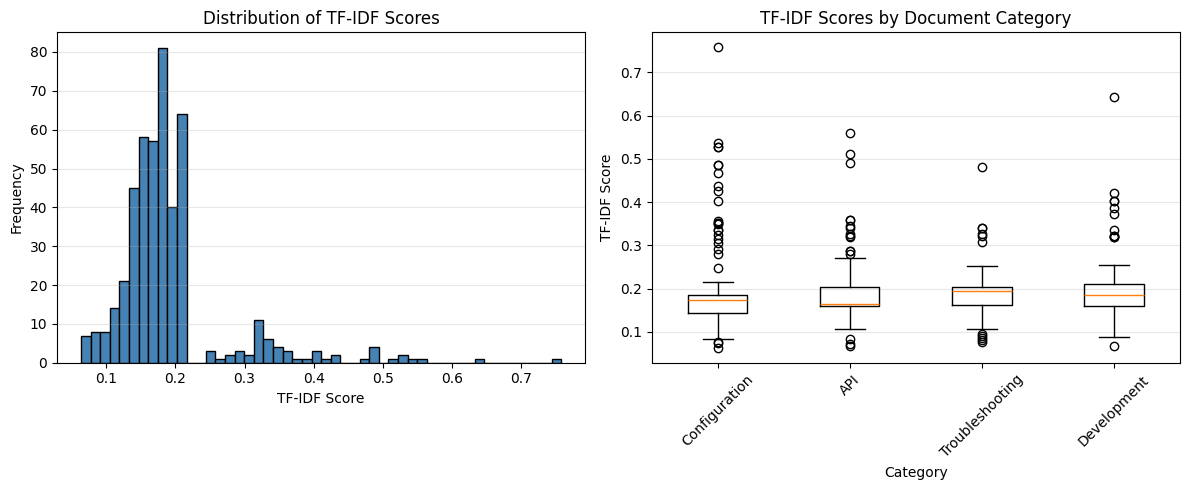

In [9]:
# Get all TF-IDF scores
all_scores = tfidf_matrix.toarray().flatten()
non_zero_scores = all_scores[all_scores > 0]

plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(non_zero_scores, bins=50, color='steelblue', edgecolor='black')
plt.xlabel('TF-IDF Score')
plt.ylabel('Frequency')
plt.title('Distribution of TF-IDF Scores')
plt.grid(axis='y', alpha=0.3)

# Box plot by category
plt.subplot(1, 2, 2)
category_scores = []
categories = df['category'].unique()

for category in categories:
    cat_indices = df[df['category'] == category].index
    cat_matrix = tfidf_matrix[cat_indices]
    cat_scores = cat_matrix.toarray().flatten()
    cat_scores = cat_scores[cat_scores > 0]
    category_scores.append(cat_scores)

plt.boxplot(category_scores, labels=categories)
plt.xlabel('Category')
plt.ylabel('TF-IDF Score')
plt.title('TF-IDF Scores by Document Category')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
# plt.savefig('tfidf_score_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# print("\n✓ Visualization saved as 'tfidf_score_distribution.png'")

## Part 9: Term Importance Heatmap

Visualize which terms are important for which documents.

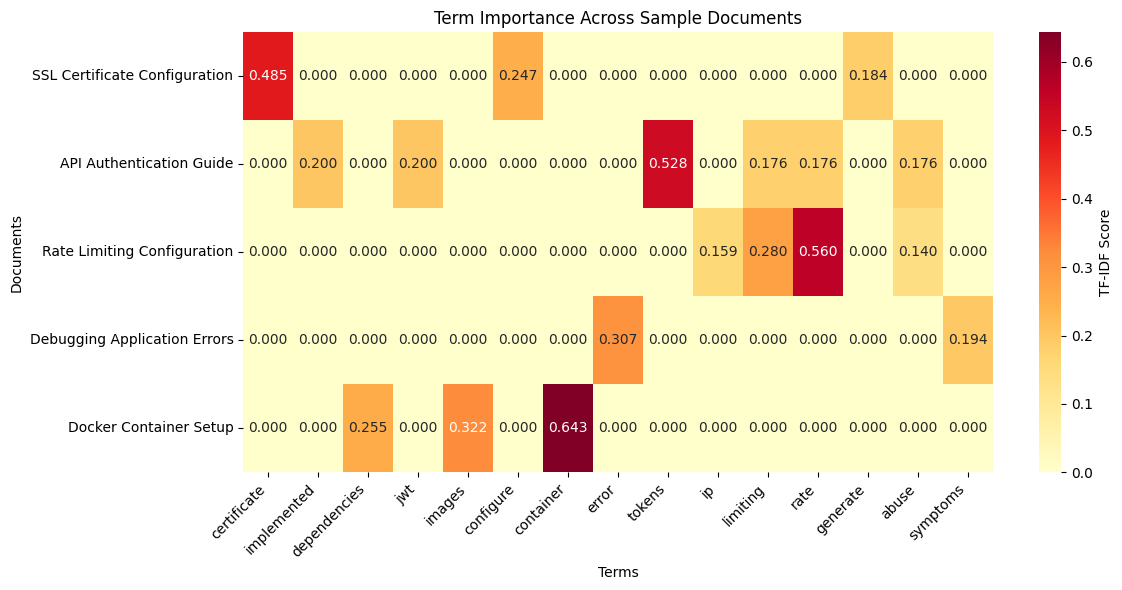

In [10]:
# Select sample documents and top terms
sample_doc_indices = [0, 2, 6, 10, 16]  # SSL, API Auth, Rate Limit, Debug, Docker
sample_docs_df = df.iloc[sample_doc_indices]

# Get top 15 terms across these documents
top_terms_set = set()
for idx in sample_doc_indices:
    top_terms = get_top_tfidf_terms(idx, tfidf, tfidf_matrix, top_n=5)
    top_terms_set.update([term for term, score in top_terms])

top_terms_list = list(top_terms_set)[:15]

# Build matrix of TF-IDF scores
feature_names = tfidf.get_feature_names_out()
term_indices = [np.where(feature_names == term)[0][0] for term in top_terms_list]

heatmap_data = np.zeros((len(sample_doc_indices), len(top_terms_list)))
for i, doc_idx in enumerate(sample_doc_indices):
    doc_vector = tfidf_matrix[doc_idx].toarray().flatten()
    for j, term_idx in enumerate(term_indices):
        heatmap_data[i, j] = doc_vector[term_idx]

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_data,
    xticklabels=top_terms_list,
    yticklabels=[df.iloc[i]['title'][:30] for i in sample_doc_indices],
    cmap='YlOrRd',
    annot=True,
    fmt='.3f',
    cbar_kws={'label': 'TF-IDF Score'}
)
plt.title('Term Importance Across Sample Documents')
plt.xlabel('Terms')
plt.ylabel('Documents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
# plt.savefig('tfidf_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# print("\n✓ Heatmap saved as 'tfidf_heatmap.png'")

## Part 10: Save the Search System

In [11]:
import pickle

# Save the vectorizer and document index
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

with open('tfidf_matrix.pkl', 'wb') as f:
    pickle.dump(tfidf_matrix, f)

with open('documentation_df.pkl', 'wb') as f:
    pickle.dump(df, f)

print("="*70)
print("SEARCH SYSTEM SAVED")
print("="*70)
print("\n✓ Files saved:")
print("  - tfidf_vectorizer.pkl")
print("  - tfidf_matrix.pkl")
print("  - documentation_df.pkl")

SEARCH SYSTEM SAVED

✓ Files saved:
  - tfidf_vectorizer.pkl
  - tfidf_matrix.pkl
  - documentation_df.pkl


In [ ]:
## How to Use the Saved Search System
"""
import pickle
from sklearn.metrics.pairwise import cosine_similarity

# Load the saved components
with open('tfidf_vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

with open('tfidf_matrix.pkl', 'rb') as f:
    doc_matrix = pickle.load(f)

with open('documentation_df.pkl', 'rb') as f:
    docs_df = pickle.load(f)

# Search function
def search(query, top_n=5):
    query_vector = vectorizer.transform([query])
    similarities = cosine_similarity(query_vector, doc_matrix).flatten()
    top_indices = similarities.argsort()[-top_n:][::-1]

    results = docs_df.iloc[top_indices].copy()
    results['score'] = similarities[top_indices]
    return results[['title', 'category', 'score']]

# Example search
results = search("how to configure SSL")
print(results)
"""

## Key Takeaways

### ✅ Advantages of TF-IDF

1. **Automatic importance weighting** - Common words get low scores
2. **Better than BoW** for search and ranking tasks
3. **No training required** - Just statistics on your corpus
4. **Interpretable** - You can see which terms matter
5. **Fast** - Suitable for production use

### ⚠️ Limitations

1. **No semantic understanding** - "good" and "excellent" are unrelated
2. **Word order ignored** - "not good" problem persists
3. **Vocabulary dependent** - New words get zero weight
4. **Dataset sensitive** - IDF changes when documents are added/removed

### 📊 When to Use TF-IDF

- ✅ Document search and retrieval
- ✅ Finding similar documents
- ✅ Keyword extraction
- ✅ Text ranking and recommendation
- ✅ As features for classification (better than BoW)

### 🚫 When NOT to Use TF-IDF

- ❌ Semantic similarity (use Word2Vec, BERT)
- ❌ Sentiment analysis with negation
- ❌ Very short documents (statistics unreliable)
- ❌ When you need to understand word relationships